# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
# For the different category I chose on cville Craigslist I selected: "Computers"
# Get page
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sya#search=1~gallery~0~0'
raw = requests.get(url,headers=header)

In [3]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

## 2. Get your search results of interest and extract data from them, using code similar to what's above.

In [4]:
listings[0].find(class_="title").get_text()

'Samsung Galaxy Book Laptop, 13.3" Intel Core i7 10th Gen,'

In [5]:
import re # Regular expressions

product_type = ['monitor', 'keyboard', 'stand', 'PC', 'laptop', 'ink', 'tower', 'router']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get product type from the title string:
    words = title.split()
    hits = [word for word in words if word in product_type] # Find product type in the title
    if len(hits) == 0:
        product = 'missing'
    else:
        product = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'product type':product})

In [6]:
data[:5]

[{'title': 'samsung galaxy book laptop, 13.3" intel core i7 10th gen,',
  'price': '$250',
  'year': nan,
  'link': 'https://charlottesville.craigslist.org/sys/d/buena-vista-samsung-galaxy-book-laptop/7783262208.html',
  'product type': 'missing'},
 {'title': '2 computers',
  'price': '$90',
  'year': nan,
  'link': 'https://charlottesville.craigslist.org/sys/d/quinque-computers/7782312652.html',
  'product type': 'missing'},
 {'title': 'targus 16 inch n2953 laptop dual fan cooling pad',
  'price': '$25',
  'year': nan,
  'link': 'https://charlottesville.craigslist.org/sys/d/charlottesville-targus-16-inch-n2953/7785984100.html',
  'product type': 'laptop'},
 {'title': 'usb keyboards',
  'price': '$15',
  'year': nan,
  'link': 'https://charlottesville.craigslist.org/sys/d/charlottesville-usb-keyboards/7785989041.html',
  'product type': 'missing'},
 {'title': '> ink tanks - new : for canon printer/scanner/copier <',
  'price': '$0',
  'year': nan,
  'link': 'https://charlottesville.cra

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

In [7]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_computers.csv') # Save data in case of a disaster
df.head()

(38, 6)


,title,price,year,link,product type,age
0,"samsung galaxy book laptop, 13.3"" intel core i...",250,NaN,https://charlottesville.craigslist.org/sys/d/b...,missing,NaN
1,2 computers,90,NaN,https://charlottesville.craigslist.org/sys/d/q...,missing,NaN
2,targus 16 inch n2953 laptop dual fan cooling pad,25,NaN,https://charlottesville.craigslist.org/sys/d/c...,laptop,NaN
3,usb keyboards,15,NaN,https://charlottesville.craigslist.org/sys/d/c...,missing,NaN
4,> ink tanks - new : for canon printer/scanner/...,0,NaN,https://charlottesville.craigslist.org/sys/d/c...,ink,NaN


With the data in and wrangled, we can now do EDA:

count      38.000000
mean      569.973684
std       587.981912
min         0.000000
25%        56.250000
50%       287.500000
75%      1018.750000
max      1900.000000
Name: price, dtype: float64


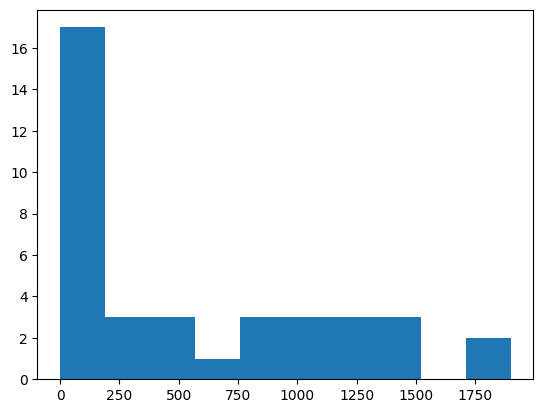

count          38
unique          6
top       missing
freq           19
Name: product type, dtype: object


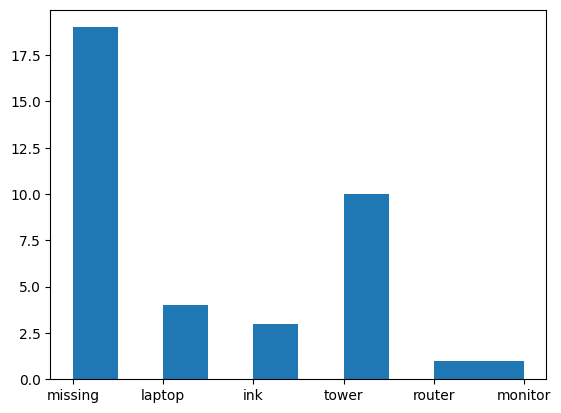

In [10]:
# EDA for price and prodyct type type:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['product type'].describe())
df['product type'].hist(grid=False)
plt.show()

In [13]:
# Price by product type:
df.loc[:,['price','product type']].groupby('product type').describe()

price                                                          \
             count         mean         std    min     25%     50%     75%   
product type                                                                 
ink            3.0     3.333333    5.773503    0.0    0.00     0.0     5.0   
laptop         4.0   466.250000  700.635129   25.0   36.25   170.0   600.0   
missing       19.0   480.736842  552.754501   15.0   82.50   250.0   700.0   
monitor        1.0   100.000000         NaN  100.0  100.00   100.0   100.0   
router         1.0    50.000000         NaN   50.0   50.00    50.0    50.0   
tower         10.0  1050.000000  455.369203   75.0  925.00  1062.5  1187.5   

                      
                 max  
product type          
ink             10.0  
laptop        1500.0  
missing       1900.0  
monitor        100.0  
router          50.0  
tower         1800.0

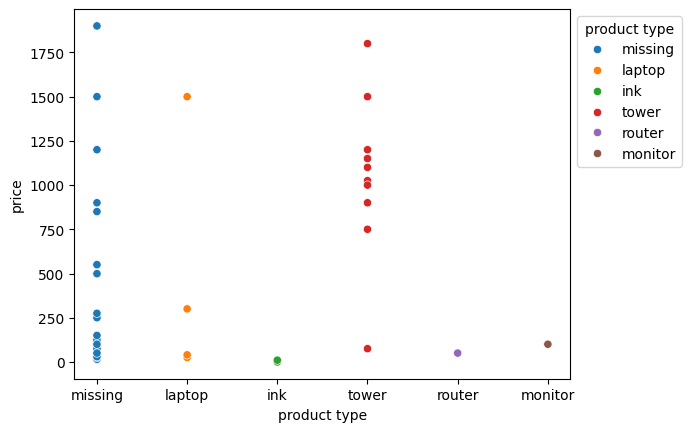

In [16]:
ax = sns.scatterplot(data=df, x='product type', y='price',hue='product type')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [20]:
#df['log_price'] = np.log(df['price'])
#df['log_product_type'] = np.log(df['product type'])

#ax = sns.scatterplot(data=df, x='log_product_type', y='log_price',hue='product_type')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#print(df.loc[:,['log_price','log_product_type']].cov())
#print(df.loc[:,['log_price','log_product_type']].corr())

In [19]:
#sns.jointplot(data=df, x='log_product_type', y='log_price',kind='hex')

## 4. Optional (skipped) - From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

## Note:
I feel I have grasped a good understanding for the basic principles of web scraping from Professor Terry's key, however, when it came to choosing my own data, I found it difficult to choose a ctaegory that showed adequate variables (specifically for scraping "age"). I tried my best to experiment with multiple categories on Craigslist, but was ultimately unsuccessful with getting any super meaningful or interesting EDA results. I know Professor has reiterated to us that he doesn't want us going crazy over it lol, so I hope that this is okay :)